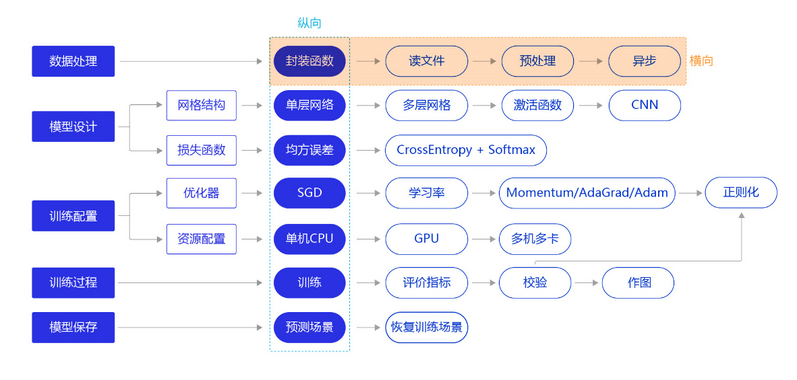

数据处理程序一般涉及五个环节：

* 读入数据
* 划分数据集
* 生成批次数据
* 训练样本集乱序
* 校验数据有效性


In [1]:
import numpy as np
import os
import gzip
import json
import random

# 读入数据并划分数据集

MNIST数据集以json格式存储在本地。

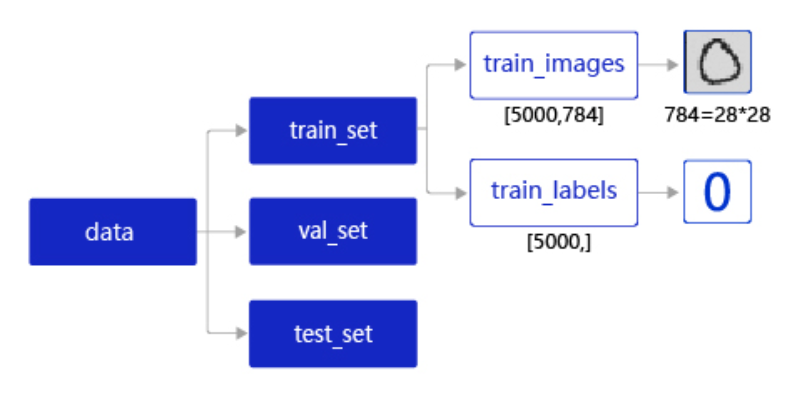

data包含三个元素的列表：train_set、val_set、 test_set。

*    train_set（训练集）：包含50000条手写数字图片和对应的标签，用于确定模型参数。
*    val_set（验证集）：包含10000条手写数字图片和对应的标签，用于调节模型超参数（如多个网络结构、正则化权重的最优选择）。
*    test_set（测试集）：包含10000条手写数字图片和对应的标签，用于估计应用效果（没有在模型中应用过的数据，更贴近模型在真实场景应用的效果）。


train_set包含两个元素的列表：train_images、train_labels。

* train_images：[5000, 784]的二维列表，包含5000张图片。每张图片用一个长度为784的向量表示，内容是28*28尺寸的像素灰度值（黑白图片）。
* train_labels：[5000, ]的列表，表示这些图片对应的分类标签，即0-9之间的一个数字。


在本地目录下读取文件名称为$mnist.json.gz$的MNIST数据，并拆分成训练集、验证集和测试集

In [29]:
datafile='./mnist.json.gz'
#加载json数据文件
data=json.load(gzip.open(datafile))
#读取到的数据区分训练集，验证集，测试集
train_set,val_set,test_set=data

#数据集相关参数
#图片高度 
IMG_ROWS=28
#图片宽度
IMG_COLS=28

#打印数据信息
imgs,labels=train_set[0],train_set[1]
print("训练数据集数量: ", len(imgs))

# 观察验证集数量
imgs, labels = val_set[0], val_set[1]
print("验证数据集数量: ", len(imgs))

# 观察测试集数量
imgs, labels = val= test_set[0], test_set[1]
print("测试数据集数量: ", len(imgs))


训练数据集数量:  50000
验证数据集数量:  10000
测试数据集数量:  10000


# 训练样本乱序、生成批次数据

* 训练样本乱序： 先将样本按顺序进行编号，建立ID集合index_list。然后将index_list乱序，最后按乱序后的顺序读取数据。

说明：

通过大量实验发现，模型对最后出现的数据印象更加深刻。训练数据导入后，越接近模型训练结束，最后几个批次数据对模型参数的影响越大。为了避免模型记忆影响训练效果，需要进行样本乱序操作。

* 生成批次数据：先设置合理的batch_size，再将数据转变成符合模型输入要求的np.array格式返回。同时，在返回数据时将Python生成器设置为yield模式，以减少内存占用。

在执行如上两个操作之前，需要先将数据处理代码封装成load_data函数，方便后续调用。load_data有三种模型：train、valid、test，分为对应返回的数据是训练集、验证集、测试集。

In [35]:
imgs,labels=train_set[0],train_set[1]
#数据集长度
imgs_length=len(imgs)
#定义数据集每个数据的序号，根据序号读数据
index_list=list(range(imgs_length))
#读取数据的批次大小
BATCHSIZE=100

#随机打乱训练数据的索引序号
np.random.shuffle(index_list)

#定义数据生成器，返回批次数据
def data_generator():
    imgs_list=[]
    labels_list=[]
    for i in index_list:
        #处理数据
        img=np.reshape(imgs[i],[1,IMG_ROWS,IMG_COLS]).astype('float32')
        label=np.reshape(labels[i],[1]).astype('float32')
        imgs_list.append(img)
        labels_list.append(label)
        if len(imgs_list)==BATCHSIZE:
            #获得一个batchsize的数据
            yield np.array(imgs_list),np.array(labels_list)
            
            imgs_list=[]
            labels_list=[]
        
    # 如果剩余数据的数目小于BATCHSIZE，
    # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        
    if len(imgs_list)>0:
            yield np.array(imgs_list),np.array(labels_list)\
        
    return data_generator

In [38]:
#声明数据读取函数，从训练集中读取数据
train_loader=data_generator

#将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，
# 同时列出数据和数据下标
for batch_id,data in enumerate(train_loader()):
    image_data, label_data=data

# 校验数据有效性

在实际应用中，原始数据可能存在标注不准确、数据杂乱或格式不统一等情况。因此在完成数据处理流程后，还需要进行数据校验，一般有两种方式：

   * 机器校验：加入一些校验和清理数据的操作。
   * 人工校验：先打印数据输出结果，观察是否是设置的格式。再从训练的结果验证数据处理和读取的有效性。


如果数据集中的图片数量和标签数量不等，说明数据逻辑存在问题，可使用assert语句校验图像数量和标签数据是否一致。

# 机器校验

In [43]:
imgs_length = len(imgs)

assert len(imgs) == len(labels),\
"length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(label))

# 封装数据读取与处理函数

In [45]:
def  load_data(mode='train'):
    datafile='./minst.json.gz'
    #加载json数据文件
    data=json.load(gzip.open(datafile))
    
    #读取到的数据区分训练集，验证集，测试集
    train_set,val_set,test_set=data
    if  mode=='train':
        imgs,labels=train_set[0],train_set[1]
    elif mode=='valid':
        imgs,labels=val_set[0],val_set[1]
    elif mode=='test':
        imgs,labels=test_set[0],test_set[1]
    else:
        raise Exception("mode can only be one of ['train','valid','test']")
        
    #校验数据
    imgs_length=len(imgs)
    
    assert len(imgs) == len(labels),\
    "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(label))
    
    #定义数据集每个数据的序号，根据序号读数据
    index_list=list(range(imgs_length))
    #读取数据的批次大小
    BATCHSIZE=100

    #随机打乱训练数据的索引序号
    np.random.shuffle(index_list)

    #定义数据生成器，返回批次数据
    def data_generator():
        imgs_list=[]
        labels_list=[]
        for i in index_list:
            #处理数据
            img=np.reshape(imgs[i],[1,IMG_ROWS,IMG_COLS]).astype('float32')
            label=np.reshape(labels[i],[1]).astype('float32')
            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list)==BATCHSIZE:
                #获得一个batchsize的数据
                yield np.array(imgs_list),np.array(labels_list)

                imgs_list=[]
                labels_list=[]

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch

        if len(imgs_list)>0:
                yield np.array(imgs_list),np.array(labels_list)\

        return data_generator

定义神经网络，利用定义好的数据处理函数，完成神经网络的训练